In [1]:
%pip install yfinance scikit-learn matplotlib pandas ipywidgets tqdm


[notice] A new release of pip is available: 25.0 -> 25.0.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
from utils.SeriesProcessor import SeriesProcessor
from classes.frameworkDetector.framework_detector import FrameworkDetector

import numpy as np
import copy
from tqdm.notebook import tqdm
import time
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.tree import DecisionTreeRegressor
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from utils import Visualizer
from utils.AuxiliaryFunctionFramework import AuxiliaryFunctionFramework

from classes.detectores.ADWINDetector import ADWINDetector
from classes.detectores.DDMDetector import DDMDetector
from classes.detectores.EDDMDetector import EDDMDetector
from classes.detectores.FHDDMDetector import FHDDMDetector
from classes.detectores.HDDM_ADetector import HDDM_ADetector
from classes.detectores.PageHinkleyDetector import PageHinkleyDetector
from classes.detectores.HDDM_WDetector import HDDM_WDetector
from classes.detectores.KSWINDetector import KSWINDetector
from classes.modelosOffline.RandomForestModelo import RandomForestModelo # Para retreino

# **1. Preparação da Base de Dados**

In [3]:
# Lista de séries temporais disponíveis (para referência)
series = [
    "AAPL",
    "B3SA3.SA",
    "^IXIC",
    "^DJI",
    "^GSPC",
    "^BVSP",
    "USDBRL=X"
]

# Definindo parâmetros para processamento
lags = 5
serie_escolhida = series[-2]  # Exemplo: ^BVSP
print(f"Processando série: {serie_escolhida}")

# Baixando os dados
serie_temporal = SeriesProcessor.baixar_dados(serie_escolhida)

# Normalizando a série temporal
serie_temporal_normalizada = SeriesProcessor.normalizar_serie(serie_temporal)
print(f"Shape da série após normalização: {serie_temporal_normalizada.shape}")

# Gerando janelas temporais (features X e target Y)
X, Y = SeriesProcessor.criar_janela_temporal(serie_temporal_normalizada, lags)
print(f"Shape dos dados de entrada (X): {X.shape}")
print(f"Shape dos dados de saída (Y): {Y.shape}")

# Definindo tamanho do conjunto inicial de treinamento (por exemplo, 20% dos dados)
initial_size = int(0.2 * len(X))
print(f"Tamanho do conjunto inicial de treinamento: {initial_size} amostras")

# Dividindo os dados em conjunto inicial e streaming
X_init = X[:initial_size]
y_init = Y[:initial_size]
X_stream = X[initial_size:]
Y_stream = Y[initial_size:]

print(f"Shape do X_init: {X_init.shape}")
print(f"Shape do Y_init: {y_init.shape}")
print(f"Shape do X_stream: {X_stream.shape}")
print(f"Shape do Y_stream: {Y_stream.shape}")

# Alternativamente, você pode definir um número fixo de amostras iniciais
# Por exemplo, 100 primeiras amostras para treinamento
fixed_initial_size = 100
X_init_fixed = X[:fixed_initial_size]
Y_init_fixed = Y[:fixed_initial_size]
X_stream_fixed = X[fixed_initial_size:]
Y_stream_fixed = Y[fixed_initial_size:]

print("\nCom tamanho fixo:")
print(f"Shape do X_init_fixed: {X_init_fixed.shape}")
print(f"Shape do Y_init_fixed: {Y_init_fixed.shape}")
print(f"Shape do X_stream_fixed: {X_stream_fixed.shape}")
print(f"Shape do Y_stream_fixed: {Y_stream_fixed.shape}")

Processando série: ^BVSP
YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed

Shape da série após normalização: (1244, 1)
Shape dos dados de entrada (X): (1239, 5)
Shape dos dados de saída (Y): (1239, 1)
Tamanho do conjunto inicial de treinamento: 247 amostras
Shape do X_init: (247, 5)
Shape do Y_init: (247, 1)
Shape do X_stream: (992, 5)
Shape do Y_stream: (992, 1)

Com tamanho fixo:
Shape do X_init_fixed: (100, 5)
Shape do Y_init_fixed: (100, 1)
Shape do X_stream_fixed: (1139, 5)
Shape do Y_stream_fixed: (1139, 1)


In [4]:
# 2. Dados Reais de Séries Financeiras
def preparar_dados_financeiros(ticker="^BVSP", periodo="5y", lags=10):
    """Prepara dados de séries financeiras para experimentos"""
    print(f"Baixando dados para {ticker} nos últimos {periodo}...")

    # Baixar dados
    serie_temporal = SeriesProcessor.baixar_dados(ticker, periodo)

    # Pré-processamento
    serie_normalizada = SeriesProcessor.normalizar_serie(serie_temporal)

    # Criar janelas temporais
    X, y = SeriesProcessor.criar_janela_temporal(serie_normalizada, lags)

    print(f"Dados processados: {X.shape[0]} amostras com {X.shape[1]} features")

    return X, y, serie_temporal

# **2. Inicialização do Framework**

In [5]:
# Definir parâmetros importantes (ajuste conforme necessário)
tamanho_janela = 150      # Tamanho da janela deslizante para avaliação e retreino
detector_escolhido = "KSWIN" # Escolha entre "DDM", "ADWIN", "KSWIN", "HDDM_W"
limiar_mse_retreino = 0.10 # Limiar de MSE para decidir se retreina ou usa modelo do pool

print("\n=== Inicialização do Framework ===")

# 1. Treinar Modelos Iniciais e Obter Scaler
print(f"Treinando modelos iniciais com {len(X_init)} amostras...")
pool_modelos, scaler = FrameworkDetector.treinar_modelos_iniciais(X_init, y_init)

if not pool_modelos:
    raise RuntimeError("Falha crítica: Não foi possível treinar nenhum modelo inicial.")

# 2. Selecionar Modelo Inicial Ativo
modelo_atual = pool_modelos[0]
print(f"\nModelo inicial ativo: {modelo_atual.nome if hasattr(modelo_atual, 'nome') else type(modelo_atual).__name__}")

# 3. Inicializar Detector
print(f"Inicializando detector: {detector_escolhido}")
# Instanciar o detector escolhido (adicione/ajuste parâmetros conforme necessário)
if detector_escolhido == "DDM":
    detector_wrapper = DDMDetector()
elif detector_escolhido == "ADWIN":
    detector_wrapper = ADWINDetector(delta=0.002)
elif detector_escolhido == "KSWIN":
    # Exemplo: Ajuste alpha, window_size, stat_size
    detector_wrapper = KSWINDetector(alpha=0.01, window_size=75, stat_size=25)
elif detector_escolhido == "HDDM_W":
     detector_wrapper = HDDM_WDetector()
else:
    raise ValueError(f"Detector '{detector_escolhido}' não suportado ou não definido.")

# 4. Inicializar Janela de Dados Recentes
#    Pré-popular a janela com os últimos dados do conjunto inicial
print(f"Inicializando janela de dados com as últimas {min(tamanho_janela, len(X_init))} amostras iniciais.")
# Usa X_init, y_init (minúsculo como no seu código)
janela_dados_recentes = list(zip(X_init[-tamanho_janela:], y_init[-tamanho_janela:]))

# 5. Estruturas para armazenar resultados do stream
erros_predicao_stream = []
estados_detector_stream = []
pontos_drift_detectados = []
metricas_rmse_stream = []
metricas_mae_stream = []
metricas_r2_stream = []
modelo_ativo_ao_longo_do_tempo = []
predicoes_stream = []

/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)



=== Inicialização do Framework ===
Treinando modelos iniciais com 247 amostras...
Ajustando Scaler nos dados iniciais...
✓ Scaler ajustado e aplicado.

Iniciando treinamento do modelo inicial: RandomForestModelo...
  ✅ Modelo RandomForestModelo treinado com sucesso

✓ Treinamento inicial concluído. Modelos no pool: 1

Modelo inicial ativo: RandomForestModelo
Inicializando detector: KSWIN
Inicializando janela de dados com as últimas 150 amostras iniciais.


# **3. Loop Principal de Detecção e Adaptação**

In [6]:
k_reset_window = 25 # Número de amostras a manter no reset parcial
min_samples_for_retrain = max(10, lags + 1) if 'lags' in locals() else 11 # Mínimo para retreinar (com fallback)
metrics_interval = 50 # Calcular métricas a cada N amostras
min_samples_for_metrics = 5 # Mínimo de amostras na janela para calcular métricas

print("\n=== Iniciando Processamento do Stream ===")
print(f"Processando {len(X_stream) if 'X_stream' in locals() else 0} amostras...")
start_time = time.time()
indice_ultimo_drift = -1

if 'X_stream' not in locals() or 'Y_stream' not in locals():
    raise NameError("Variáveis X_stream ou Y_stream não definidas. Execute as células anteriores.")

for i, (x_t, y_t) in enumerate(tqdm(zip(X_stream, Y_stream), total=len(X_stream), desc="Stream")):
    indice_global = initial_size + i

    # 1. Predição
    fallback_pred = np.mean([y for _, y in janela_dados_recentes]) if janela_dados_recentes else np.mean(y_init)
    y_pred, x_t_scaled_pred = AuxiliaryFunctionFramework.perform_prediction(
        modelo_atual, scaler, x_t, fallback_pred
    )
    predicoes_stream.append(y_pred)

    # 2. Erro e Atualização do Detector
    erro = abs(y_t - y_pred)
    AuxiliaryFunctionFramework.update_detector(detector_wrapper, erro)
    erros_predicao_stream.append(erro) # Armazena erro

    # 3. Estado do Detector
    estado = AuxiliaryFunctionFramework.get_detector_state(detector_wrapper)
    estados_detector_stream.append(estado) # Armazena estado

    # 4. Ação Baseada no Estado
    if estado == "NORMAL":
        pass
    elif estado == "ALERTA":
        AuxiliaryFunctionFramework.handle_alert_state(modelo_atual, x_t_scaled_pred, y_t)
    elif estado == "MUDANÇA":
        pontos_drift_detectados.append(indice_global)
        print(f"\n!!! Drift detectado no índice global {indice_global} (Detector: {detector_escolhido}) !!!")
        indice_ultimo_drift = indice_global

        # Chama a função auxiliar para tratar o estado de mudança
        # Ela retorna o novo modelo ativo e a janela modificada
        novo_modelo_atual, nova_janela_dados_recentes = AuxiliaryFunctionFramework.handle_change_state(
            current_model=modelo_atual,
            pool=pool_modelos,
            window=janela_dados_recentes,
            scaler=scaler,
            threshold=limiar_mse_retreino,
            min_samples_retrain=min_samples_for_retrain,
            k_reset=k_reset_window
        )
        # Atualiza as variáveis no escopo do loop
        modelo_atual = novo_modelo_atual
        janela_dados_recentes = nova_janela_dados_recentes


    # Armazena qual modelo está ativo APÓS qualquer mudança de estado
    modelo_ativo_ao_longo_do_tempo.append(AuxiliaryFunctionFramework.get_model_name(modelo_atual))

    # 5. Calcular Métricas Periodicamente
    if i > 0 and i % metrics_interval == 0:
        # Passa as listas de métricas para a função poder adicionar a elas
        AuxiliaryFunctionFramework.calculate_and_store_metrics(
            model=modelo_atual,
            scaler=scaler,
            window=janela_dados_recentes,
            index=indice_global,
            min_samples=min_samples_for_metrics,
            metricas_rmse_stream=metricas_rmse_stream,
            metricas_mae_stream=metricas_mae_stream,
            metricas_r2_stream=metricas_r2_stream
        )

    # 6. Atualizar Janela de Dados Recentes (SEMPRE no final)
    janela_dados_recentes = AuxiliaryFunctionFramework.update_window(
        window=janela_dados_recentes,
        data_point=(x_t, y_t),
        max_size=tamanho_janela
    )

# --- Fim do Loop ---
end_time = time.time()
print(f"\n=== Processamento do Stream Concluído ===")
print(f"Tempo total: {end_time - start_time:.2f} segundos")
print(f"Drifts detectados: {len(pontos_drift_detectados)}")
if pontos_drift_detectados:
    print(f"  Nos índices: {pontos_drift_detectados}")
print(f"Tamanho final do pool: {len(pool_modelos)}")


=== Iniciando Processamento do Stream ===
Processando 992 amostras...


Stream:   0%|          | 0/992 [00:00<?, ?it/s]


!!! Drift detectado no índice global 321 (Detector: KSWIN) !!!
  Adicionando cópia de 'RandomForestModelo' ao pool.
  Tamanho do pool agora: 2
  Selecionando melhor modelo do pool...
    Modelo 0 (RandomForestModelo): MSE = 0.0773
    Modelo 1 (RandomForestModelo): MSE = 0.0773
  ✓ Melhor modelo selecionado: RandomForestModelo (MSE: 0.0773)
  Avaliando desempenho de 'RandomForestModelo'...
  MSE na janela: 0.0773. Limiar: 0.1000
  ✓ Ativando modelo do pool: RandomForestModelo

!!! Drift detectado no índice global 445 (Detector: KSWIN) !!!
  Adicionando cópia de 'RandomForestModelo' ao pool.
  Tamanho do pool agora: 3
  Selecionando melhor modelo do pool...
    Modelo 0 (RandomForestModelo): MSE = 0.0305
    Modelo 1 (RandomForestModelo): MSE = 0.0305
    Modelo 2 (RandomForestModelo): MSE = 0.0305
  ✓ Melhor modelo selecionado: RandomForestModelo (MSE: 0.0305)
  Avaliando desempenho de 'RandomForestModelo'...
  MSE na janela: 0.0305. Limiar: 0.1000
  ✓ Ativando modelo do pool: RandomF

/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


  ✓ Novo modelo (RandomForestModelo) treinado.
  ✓ Novo modelo retreinado ativado: RandomForestModelo

!!! Drift detectado no índice global 1053 (Detector: KSWIN) !!!
  Adicionando cópia de 'RandomForestModelo' ao pool.
  Tamanho do pool agora: 7
  Selecionando melhor modelo do pool...
    Modelo 0 (RandomForestModelo): MSE = 0.1823
    Modelo 1 (RandomForestModelo): MSE = 0.1823
    Modelo 2 (RandomForestModelo): MSE = 0.1823
    Modelo 3 (RandomForestModelo): MSE = 0.1823
    Modelo 4 (RandomForestModelo): MSE = 0.1823
    Modelo 5 (RandomForestModelo): MSE = 0.1823
    Modelo 6 (RandomForestModelo): MSE = 0.0196
  ✓ Melhor modelo selecionado: RandomForestModelo (MSE: 0.0196)
  Avaliando desempenho de 'RandomForestModelo'...
  MSE na janela: 0.0196. Limiar: 0.1000
  ✓ Ativando modelo do pool: RandomForestModelo

!!! Drift detectado no índice global 1160 (Detector: KSWIN) !!!
  Adicionando cópia de 'RandomForestModelo' ao pool.
  Tamanho do pool agora: 8
  Selecionando melhor modelo d

# **4. Análise e Visualização dos Resultados**


=== Análise dos Resultados do Stream ===


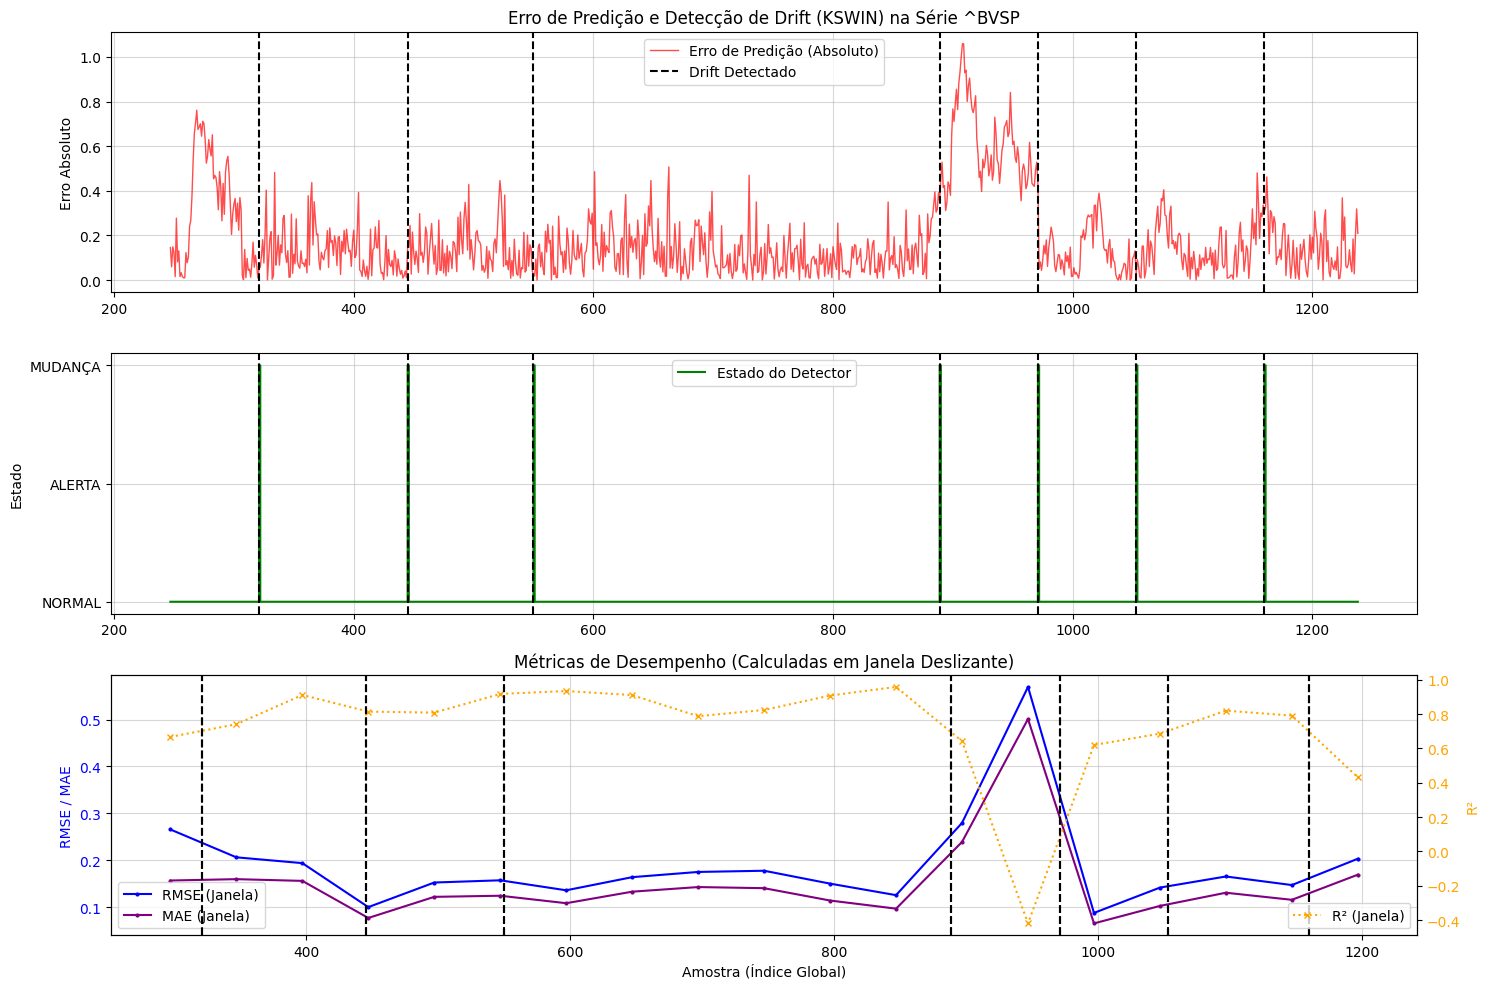


Métricas Globais no Stream:
  MSE: 0.0673
  MAE: 0.1836

Contagem de Uso dos Modelos Durante o Stream:
RandomForestModelo    992
Name: count, dtype: int64


In [7]:
Visualizer.analisar_e_visualizar_resultados_stream(
    initial_size=initial_size,
    erros_predicao_stream=erros_predicao_stream,
    estados_detector_stream=estados_detector_stream,
    pontos_drift_detectados=pontos_drift_detectados,
    metricas_rmse_stream=metricas_rmse_stream,
    metricas_mae_stream=metricas_mae_stream,
    metricas_r2_stream=metricas_r2_stream,
    modelo_ativo_ao_longo_do_tempo=modelo_ativo_ao_longo_do_tempo,
    detector_escolhido=detector_escolhido,
    serie_escolhida=serie_escolhida
)


=== Visualização: Valores Reais vs. Previsões ===


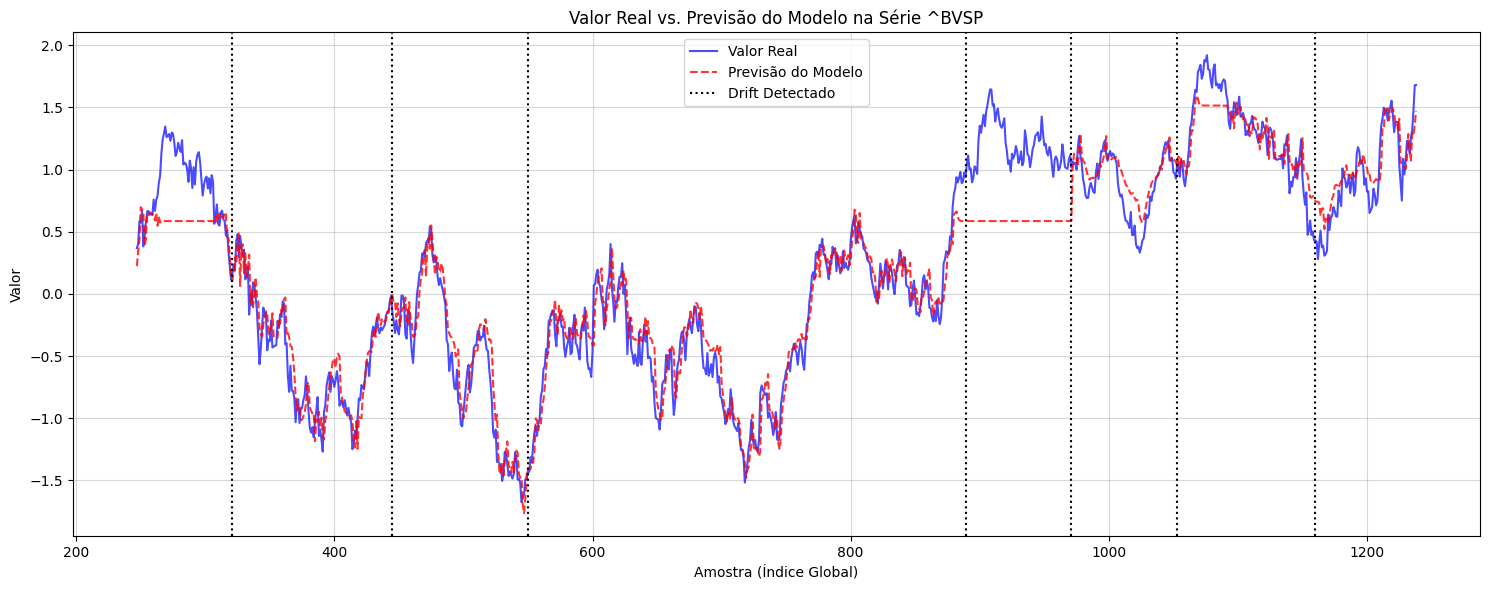

In [8]:
Visualizer.visualizar_previsoes_vs_real(
    initial_size=initial_size,
    Y_stream=Y_stream,
    predicoes_stream=predicoes_stream,
    pontos_drift_detectados=pontos_drift_detectados,
    serie_escolhida=serie_escolhida
)